In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
sns.set_context("paper",font_scale=1.5, rc={"lines.linewidth":2})
sns.set_theme(style="ticks", color_codes=True)
sns.set_style("white")

In [3]:
import decoupler as dc

In [6]:
dc.__version__

'1.1.0'

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [8]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [9]:
adata_1 = sc.read_10x_mtx(
    './matrix_r1/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)  
adata_2 = sc.read_10x_mtx(
    './matrix_r2/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)  

... reading from cache file cache/matrix_r1-matrix.h5ad
... reading from cache file cache/matrix_r2-matrix.h5ad


In [10]:
adata= adata_1.concatenate(adata_2, batch_key='rep')

/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [11]:
clones = pd.read_csv('./220404_cell_clone_info.csv')

In [12]:
# Change the clone data to 
clones[['cellBC_rew', 'rep']] = clones['cellBC'].str.split('-', expand=True)

In [13]:
clones['cellBC_rew'] =  clones['cellBC_rew'].mask(clones['rep'].eq('1'), clones['cellBC_rew']+ '-1-0')
clones['cellBC_rew'] =  clones['cellBC_rew'].mask(clones['rep'].eq('2'), clones['cellBC_rew']+ '-1-1')

In [14]:
clones_info = clones[['cellBC_rew', 'clone']]

In [15]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 35 cells that have less than 200 genes expressed
filtered out 15105 genes that are detected in less than 3 cells


In [16]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

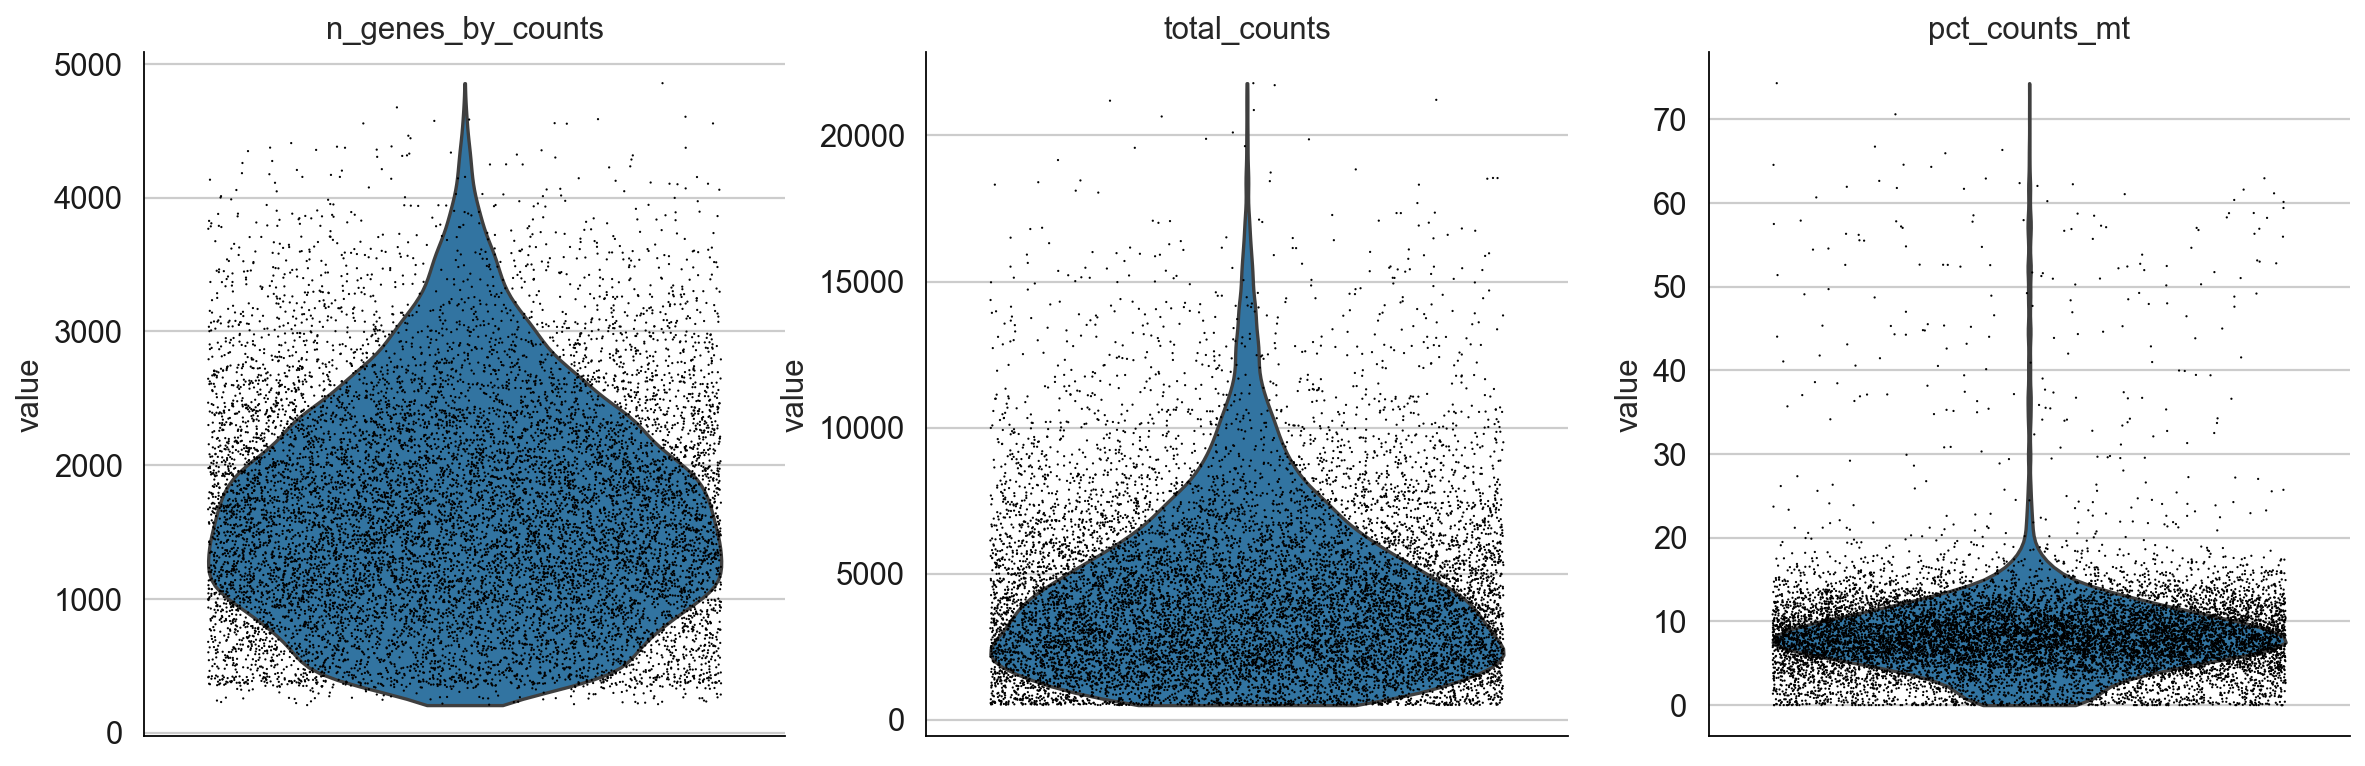

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

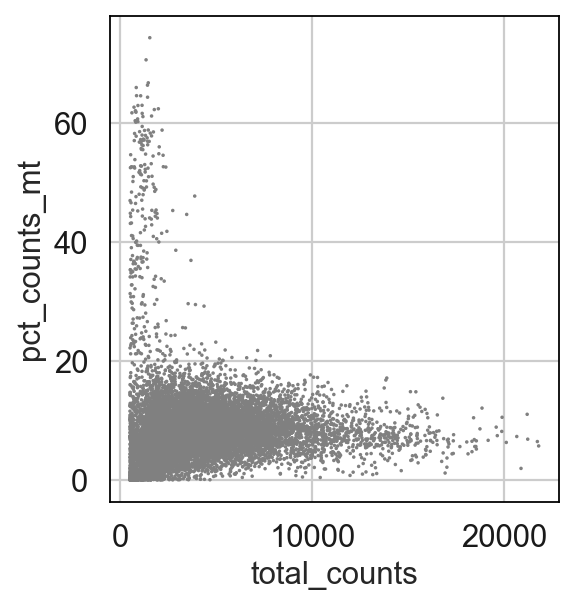

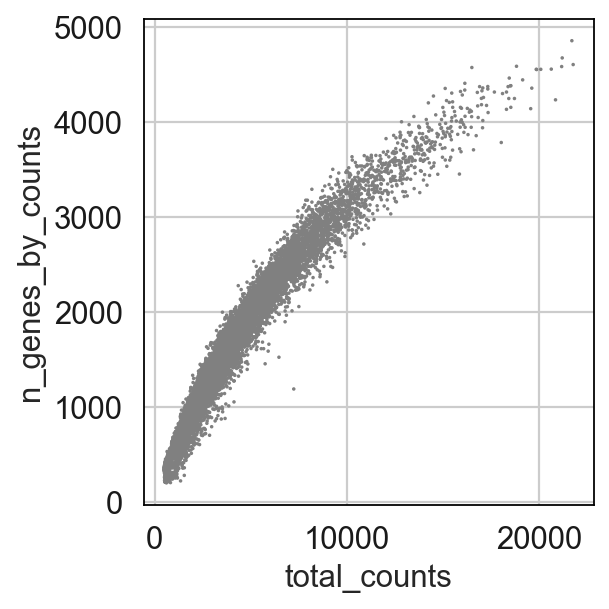

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [19]:
#adata = adata[adata.obs.total_counts < 60000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

In [20]:
sc.pp.normalize_total(adata, exclude_highly_expressed=True, target_sum=1e4)

/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['TXNIP', 'RPS18', 'HBG1', 'HBG2', 'PRG2', 'FTH1', 'MALAT1', 'HSP90B1', 'HBZ', 'MT2A', 'FTL', 'TIMP1']
    finished (0:00:00)


In [21]:
sc.pp.log1p(adata)

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=15, min_disp=0.01)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


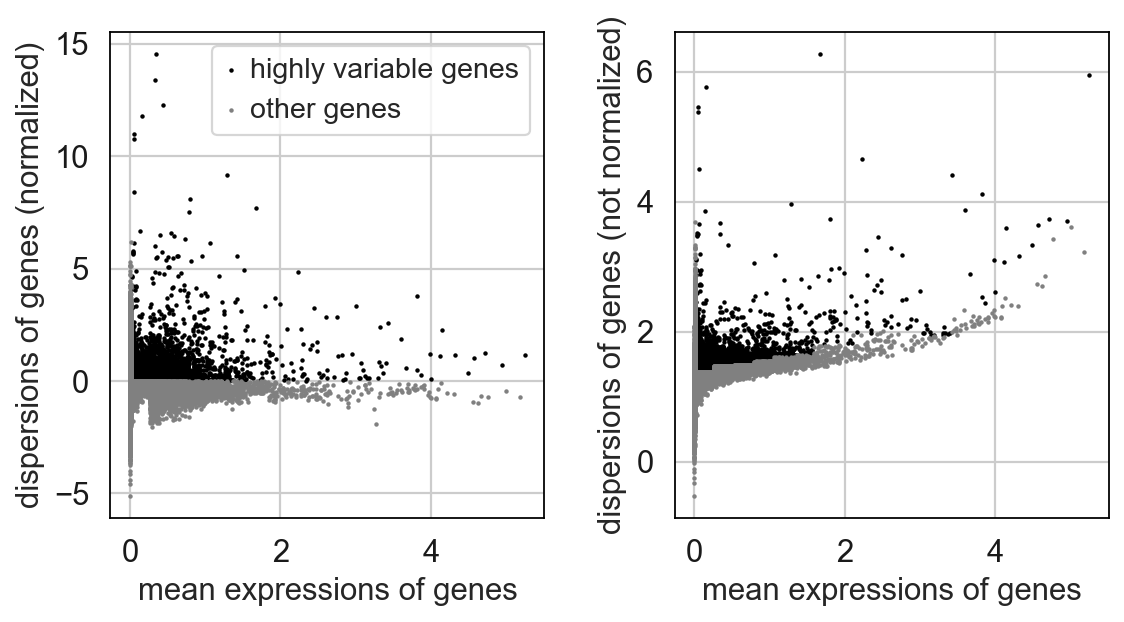

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


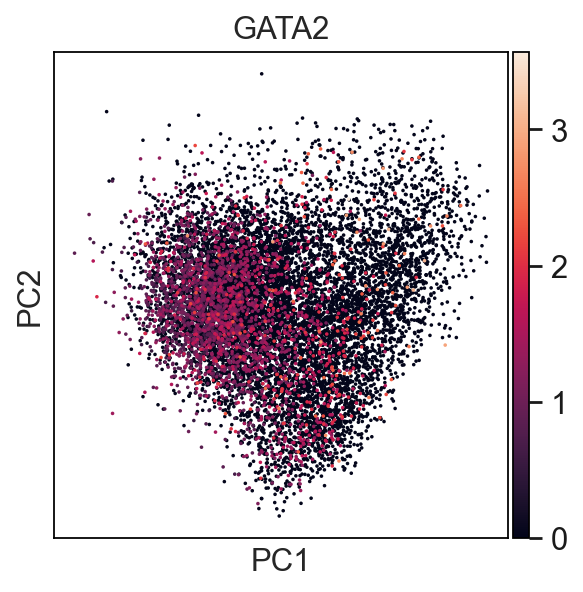

In [25]:
sc.pl.pca(adata, color = 'GATA2')

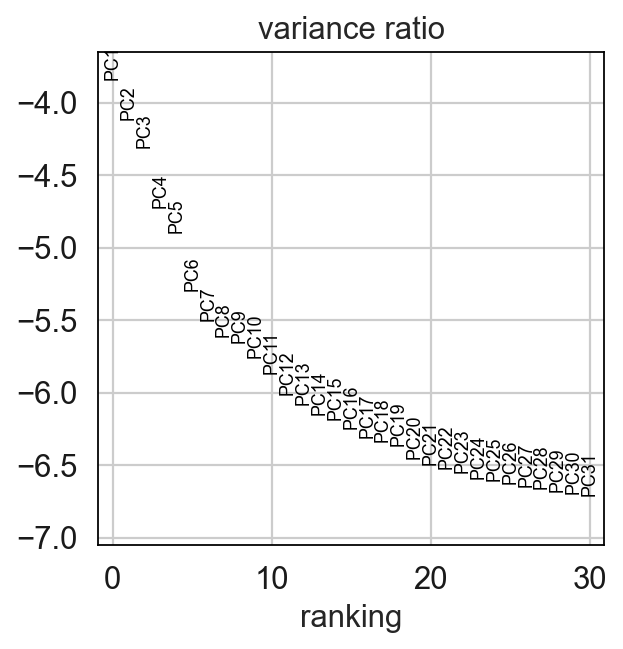

In [26]:
sc.pl.pca_variance_ratio(adata, log=True)

In [29]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=31, random_state=1)

computing neighbors
    using 'X_pca' with n_pcs = 31
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [30]:
sc.tl.umap(adata, random_state=1)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [31]:
sc.tl.leiden(adata, resolution = 0.2, key_added='clusters', random_state=1)

running Leiden clustering
    finished: found 3 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


[<AxesSubplot:title={'center':'clusters'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'HBG2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'NCK2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'GATA2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'CD24'}, xlabel='UMAP1', ylabel='UMAP2'>]

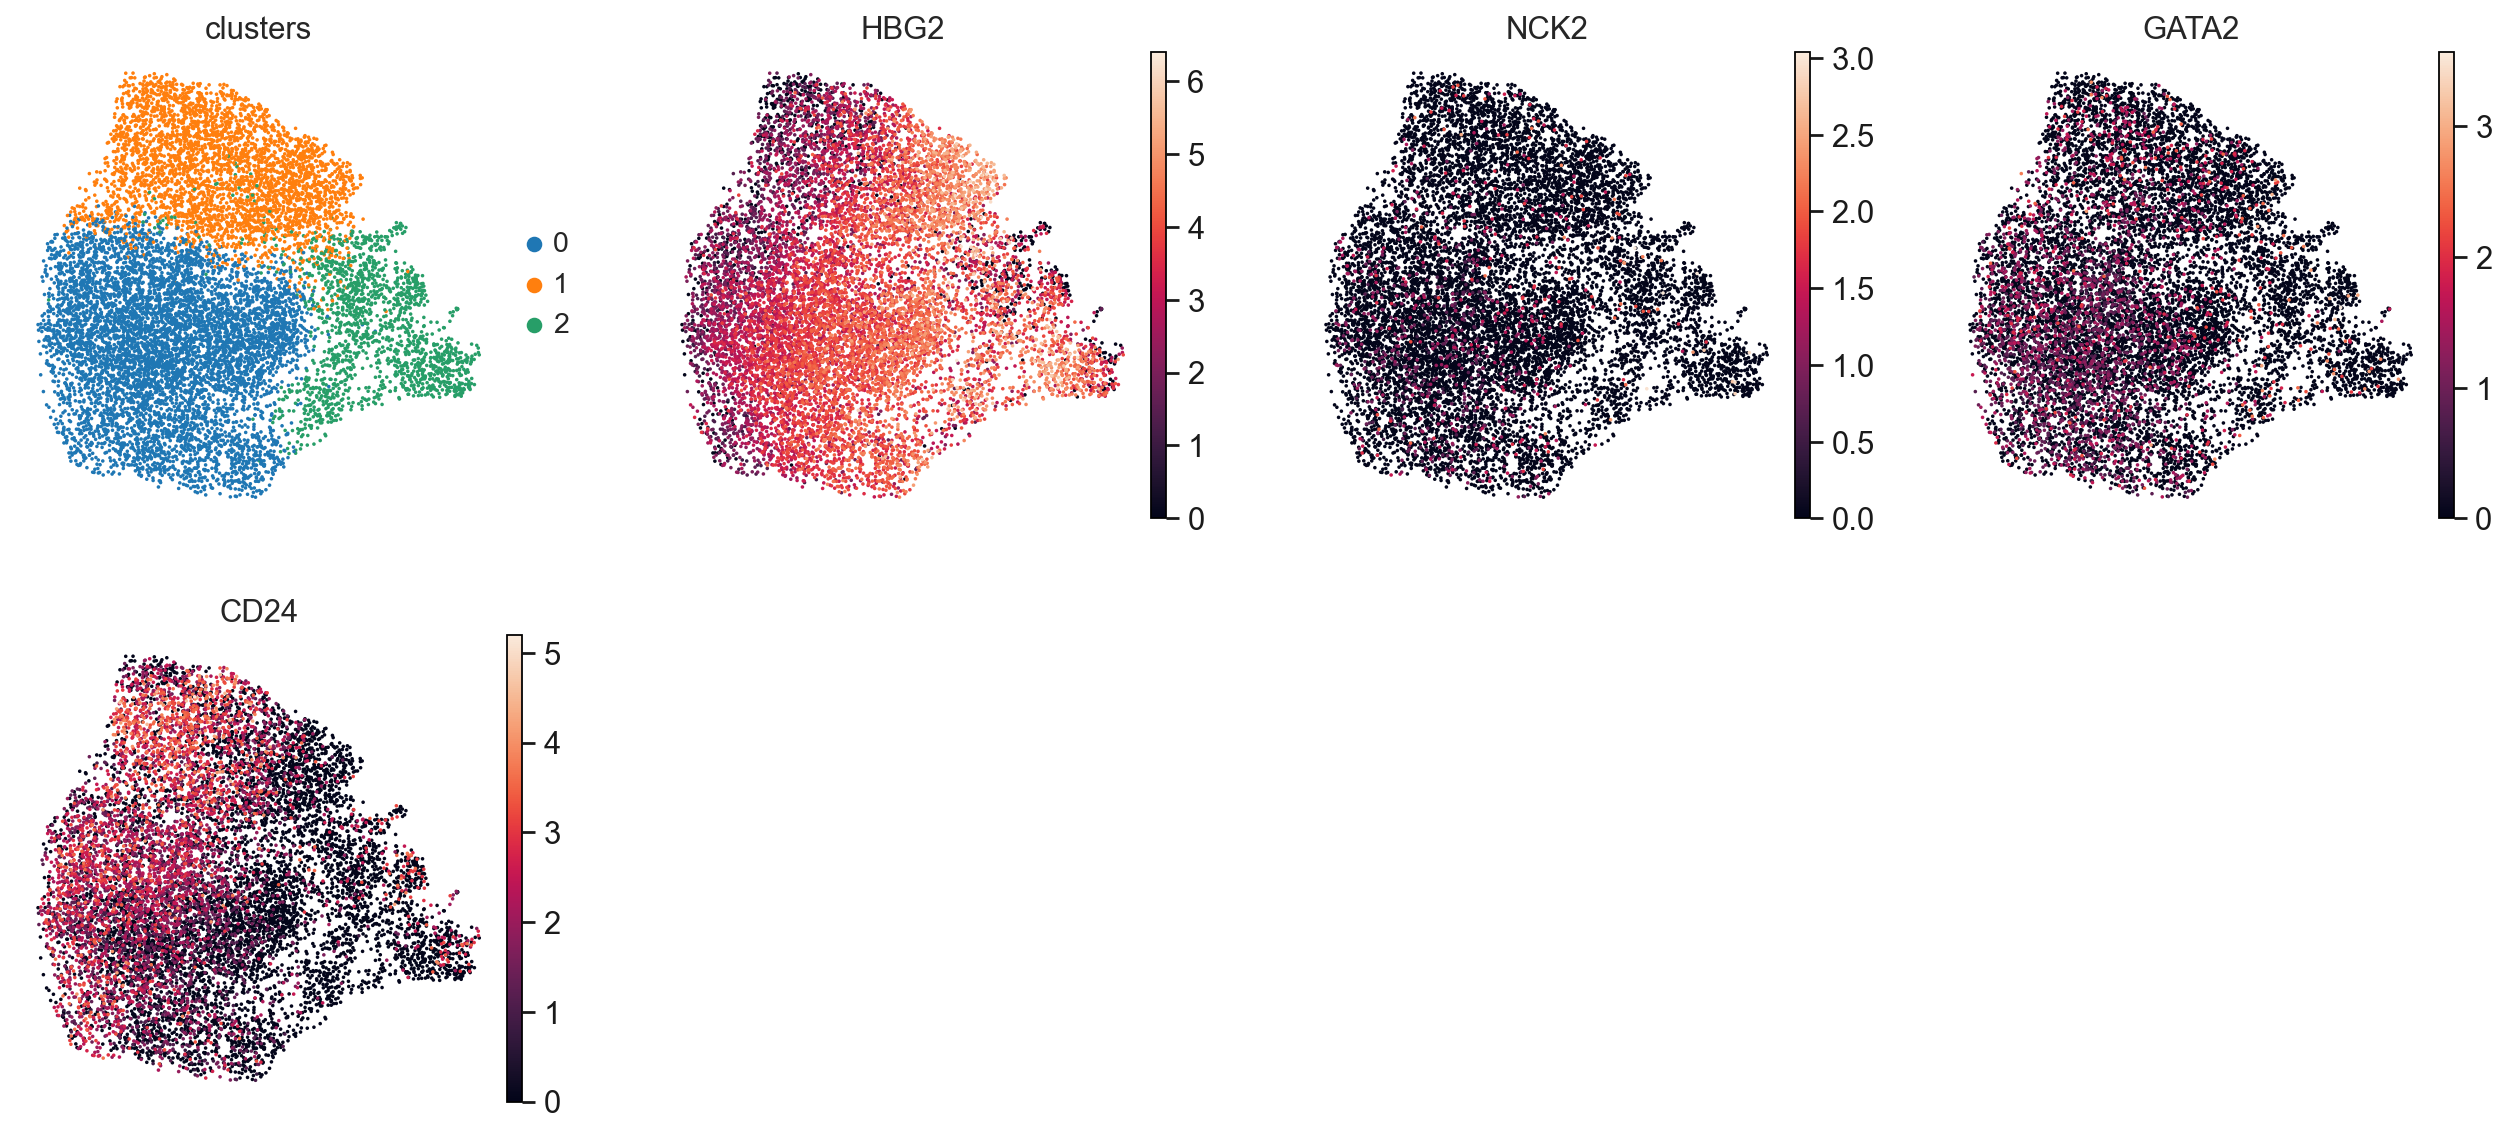

In [32]:
sc.pl.umap(adata, color=[ 'clusters', 'HBG2', 'NCK2', 'GATA2', 'CD24'],frameon=False, show=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


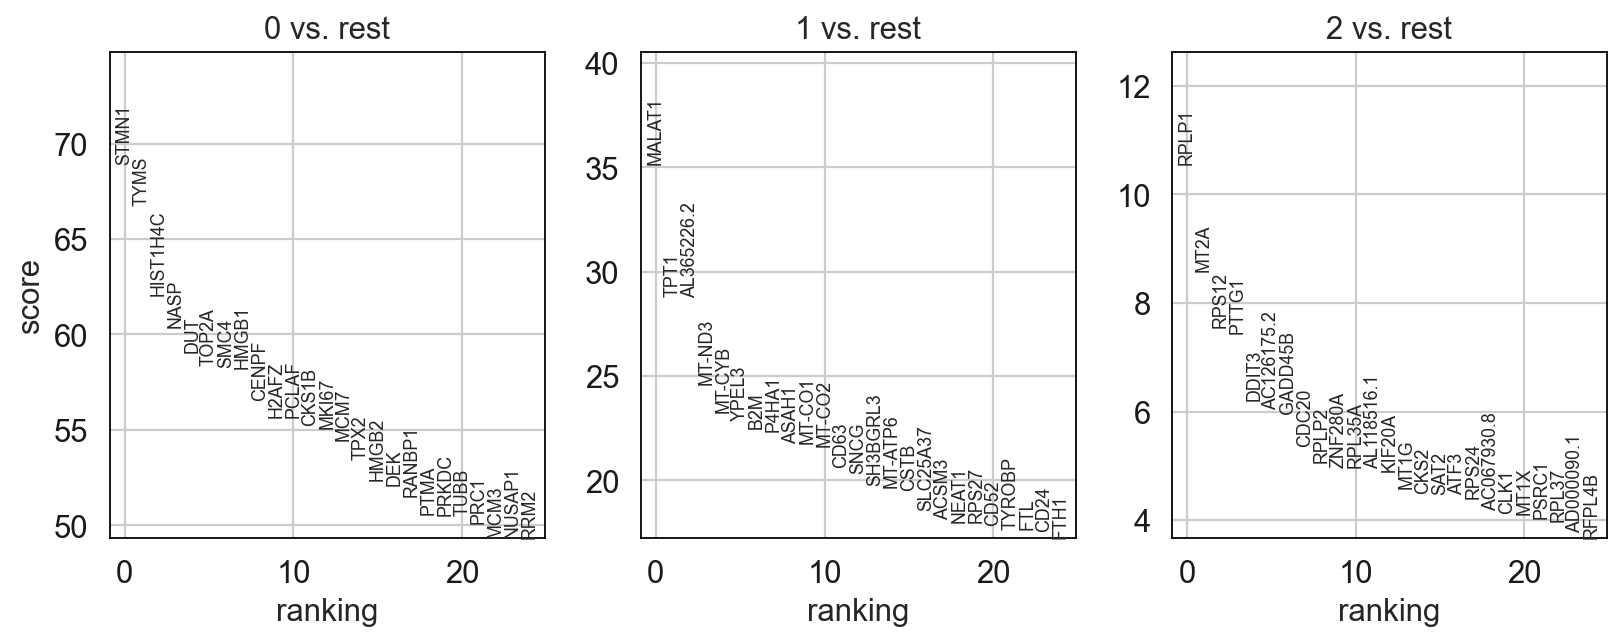

In [33]:
sc.tl.rank_genes_groups(adata, 'clusters', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [34]:
clones_info = clones_info.rename(columns={'cellBC_rew': 'cellBC'})
cell_list = adata.obs.index.tolist()
cell_list = pd.DataFrame(cell_list, columns=['cellBC'])
ordered_label = pd.merge(cell_list, clones_info, on='cellBC', how = 'left')
labels = ordered_label.clone.to_list()

In [35]:
adata.obs['clones'] = labels

the obs value 'clones' has more than 103 categories. Uniform 'grey' color will be used for all categories.


[<AxesSubplot:title={'center':'clusters'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'clones'}, xlabel='UMAP1', ylabel='UMAP2'>]

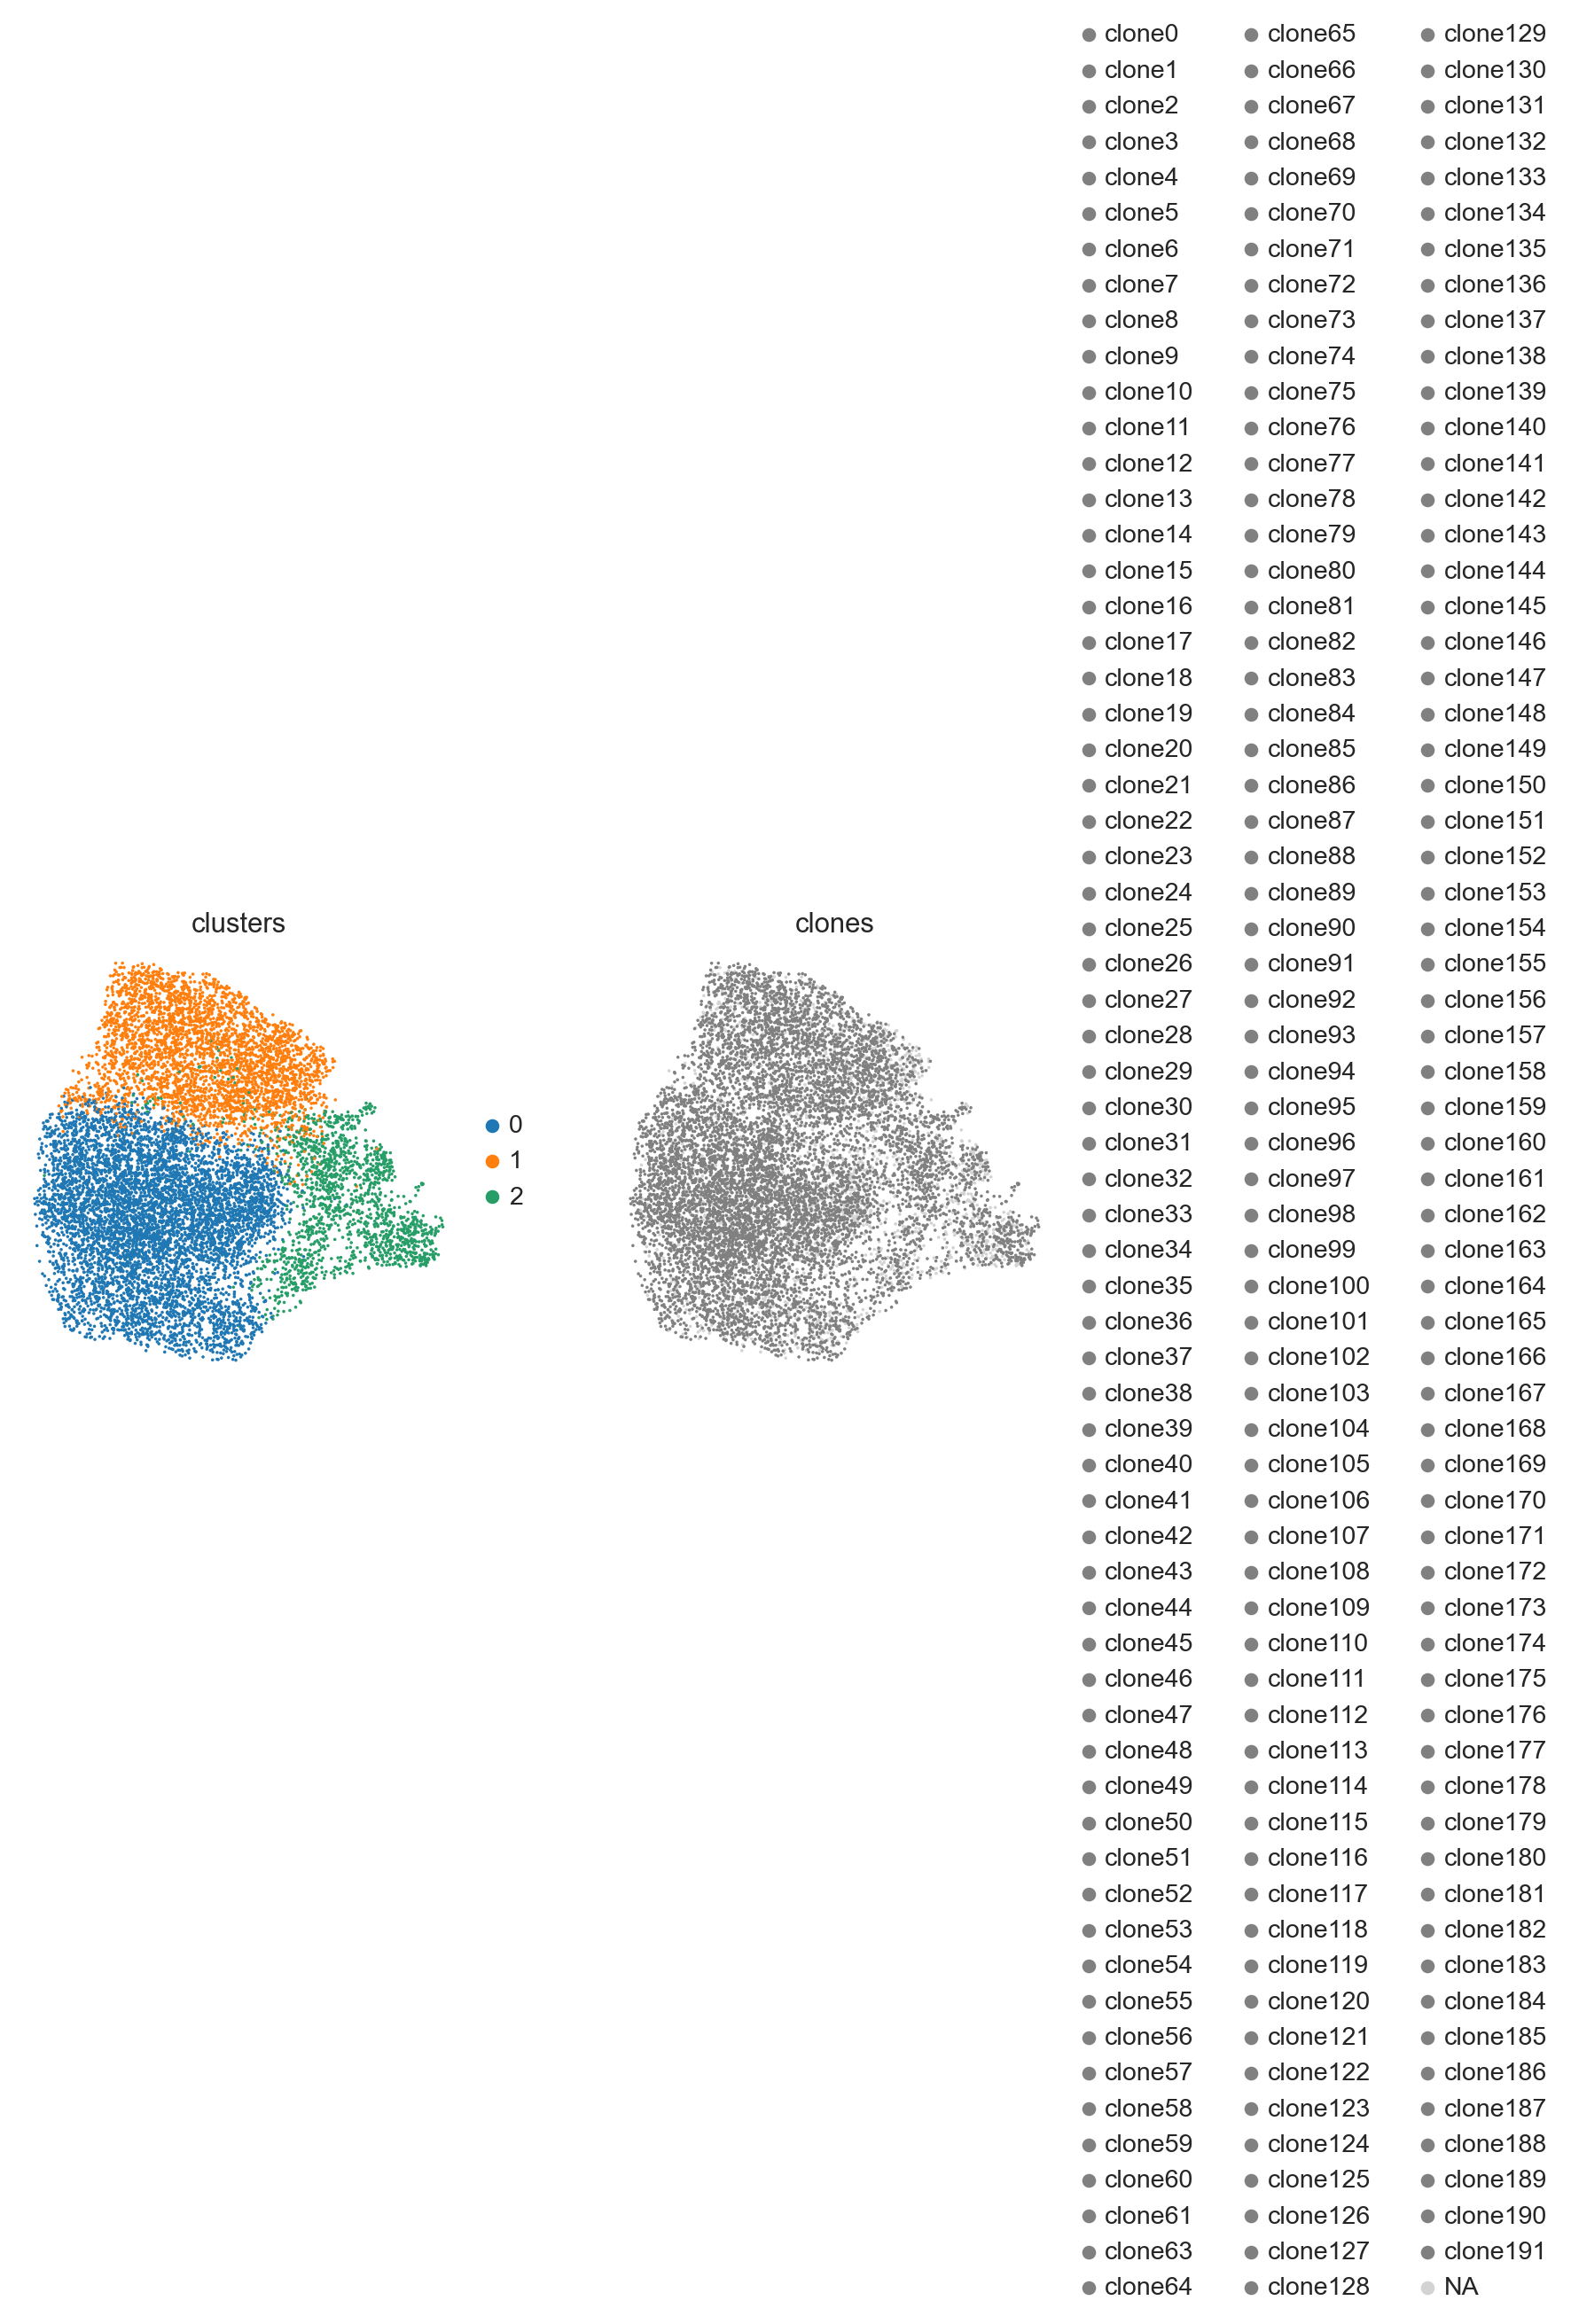

In [36]:
sc.pl.umap(adata, color=[ 'clusters', 'clones'],frameon=False, show=False)

### Now we look at if the integration of a reporter gene alters the gene at the place of integration

In [37]:
# First we read in the tripBC and genomic location informaation
trip_clones = pd.read_csv('./20220404_trip_clones.tsv', sep= '\t')
trip_in_gene = pd.read_csv('tBCs_in_genes.tsv', sep= '\t')

In [38]:
# Filter out only the genes that are in the latest pool
trip_in_gene = trip_in_gene[trip_in_gene.pool.str.contains('LP1_latest')]
trip_in_gene = trip_in_gene[['tBC','gene_name']]

In [39]:
clone_name = list(trip_clones.clone.unique())
trip_in_gene_clone = pd.DataFrame(columns = ['tBC', 'gene_name', 'clone'])
for clone in clone_name:
    tripBCs = trip_clones.loc[trip_clones.clone == clone, 'tBC'].to_list()
    trip_in_gene_slice = trip_in_gene.loc[trip_in_gene.tBC.isin(tripBCs)]
    trip_in_gene_slice['clone'] = clone
    trip_in_gene_clone = pd.concat([trip_in_gene_clone, trip_in_gene_slice])


/var/folders/y1/wff22b4j5_lbcg6_ryg7_6vr0000gn/T/ipykernel_68703/4183374698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_in_gene_slice['clone'] = clone
/var/folders/y1/wff22b4j5_lbcg6_ryg7_6vr0000gn/T/ipykernel_68703/4183374698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_in_gene_slice['clone'] = clone
/var/folders/y1/wff22b4j5_lbcg6_ryg7_6vr0000gn/T/ipykernel_68703/4183374698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [40]:
trip_in_gene_clone.loc[trip_in_gene_clone.clone == 'clone3']

tBC gene_name   clone
81   AAGTAGCGTCATGCTC    DEPDC1  clone3
94   GGTAACTACTTAAATA     SMYD3  clone3
122  TTTTCTTGTTAAAGTC    ZNF131  clone3
149  TACCAATCTCAATAGT      CASK  clone3
153  TTGTTTGTCTTTGCAT     MEIS1  clone3
165  TGACTTGTGTGGGTAA   C8orf37  clone3
177  ACCCGCACCCTCCTAA     NUP88  clone3

In [41]:
clones = trip_in_gene_clone['clone'].unique().tolist()
for clone in clones:
    if clone != 'nan':
        adata.obs[clone] = adata.obs['clones'].eq(clone)
        adata.obs[clone] = np.where(adata.obs[clone] == True, clone, 'bg')

In [42]:
trip_in_gene_clone['gene_name_shuffled'] = np.random.permutation(trip_in_gene_clone.gene_name.values)

In [43]:
adata.layers['counts'] = adata.X
final_pop = []
for clone in clones:
    padata = dc.get_pseudobulk(adata, sample_col='rep', groups_col=clone, layer='counts', min_prop=0.00001, min_smpls=2)
    sc.pp.normalize_total(padata, target_sum=1e6)
    sc.pp.log1p(padata)
    mtx = pd.DataFrame(padata.X)
    mtx.columns=padata.var_names
    mtx.index=padata.obs_names
    clone_slice = trip_in_gene_clone.loc[trip_in_gene_clone.clone == clone]
    # Now we loop through the genes to see if they are in the pseudobulk comparison
    for index, row in clone_slice.iterrows():
        gene = row['gene_name']
        tBC = row['tBC']
        if gene in mtx.columns:
            pop_list = mtx[gene].to_list()
            for ind, pop in enumerate(pop_list):
                if ind == 0:
                    report_list = [gene, clone, tBC, pop, 'rep1', 'control']
                    final_pop.append(report_list)
                elif ind == 1:
                    report_list = [gene, clone, tBC, pop, 'rep2', 'control']
                    final_pop.append(report_list)
                elif ind == 2:
                    report_list = [gene, clone, tBC, pop, 'rep1', 'insert']
                    final_pop.append(report_list)
                elif ind == 3:
                    report_list = [gene, clone, tBC, pop, 'rep2', 'insert']
                    final_pop.append(report_list)
pop_df = pd.DataFrame(final_pop, columns = ['gene','clone', 'tBC', 'pseudo','rep', 'condition'])

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/siqizhao/opt/miniconda3/envs/scwork/lib/python3.9/site-packages/decoupler/utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=n

In [44]:
# Remove the ones that have 0 counts
pop_df = pop_df.loc[pop_df.pseudo!= 0]


In [45]:
genes = pop_df.gene.unique().tolist()
good_gene = []
for gene in genes:
    if len(pop_df.loc[pop_df.gene == gene]) == 4:
        good_gene.append(gene)
pop_df = pop_df.loc[pop_df.gene.isin(good_gene)]

In [43]:
pop_df.to_csv('220520_insertion_effect.csv')

In [46]:
len(pop_df.gene.unique())

65

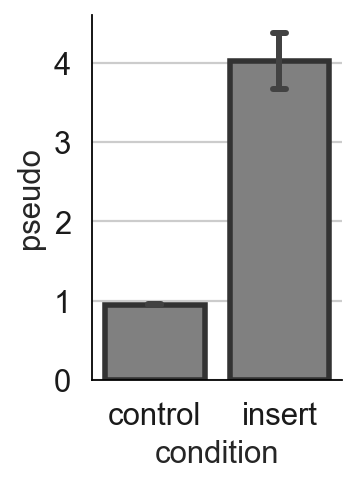

In [47]:
fig,ax = plt.subplots(figsize=(2,3))
sns.barplot(x = 'condition', y = 'pseudo', color = 'grey', edgecolor=".2", ci = "sd", linewidth=2.5, capsize = 0.1, data = pop_df[pop_df.gene == 'SPRY1'])
sns.despine()
#plt.title('NCK2')
#plt.savefig('SPY1_insertion_effect.pdf', dpi = 300)

Text(0.5, 1.0, 'ZPF69')

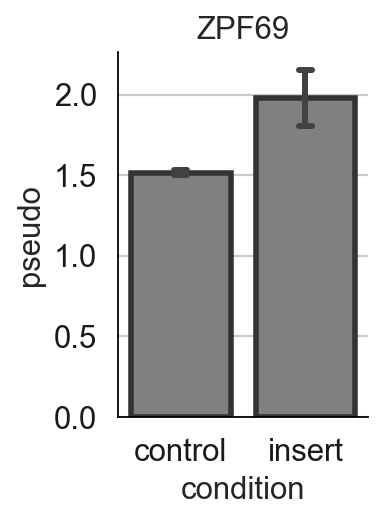

In [48]:
fig,ax = plt.subplots(figsize=(2,3))
sns.barplot(x = 'condition', y = 'pseudo', color = 'grey', edgecolor=".2", ci = "sd", linewidth=2.5, capsize = 0.1, data = pop_df[pop_df.gene == 'ZFP69'])
sns.despine()
plt.title('ZPF69')
#plt.savefig('ZPF69_insertion_effect.pdf', dpi = 300)

Text(0.5, 1.0, 'DOCK2')

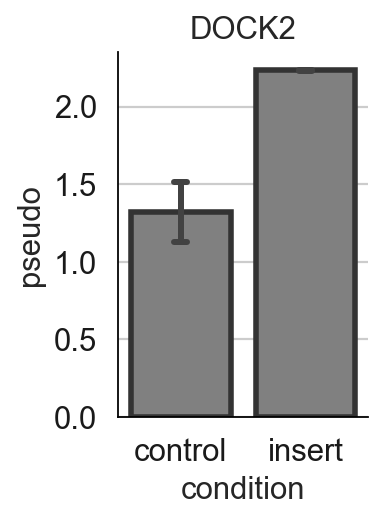

In [49]:
fig,ax = plt.subplots(figsize=(2,3))
sns.barplot(x = 'condition', y = 'pseudo', color = 'grey', edgecolor=".2", ci = "sd", linewidth=2.5, capsize = 0.1, data = pop_df[pop_df.gene == 'ZC3H12C'])
sns.despine()
plt.title('DOCK2')
#plt.savefig('DOCK2_insertion_effect.pdf', dpi = 300)

Text(0.5, 1.0, 'C12orf40')

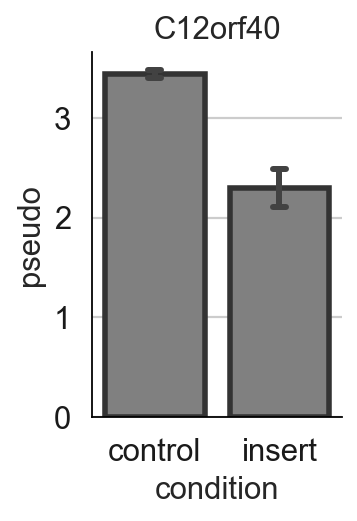

In [50]:
fig,ax = plt.subplots(figsize=(2,3))
sns.barplot(x = 'condition', y = 'pseudo', color = 'grey', edgecolor=".2", ci = "sd", linewidth=2.5, capsize = 0.1, data = pop_df[pop_df.gene == 'DOCK2'])
sns.despine()
plt.title('C12orf40')
#plt.savefig('C12orf40_insertion_effect.pdf', dpi = 300)

In [51]:
pop_df['pseudo_int'] = round(pop_df['pseudo']*1000)

In [52]:
pop_df_control = pop_df.loc[pop_df.condition == 'control']

In [53]:
pop_df_control 

gene     clone               tBC    pseudo   rep condition  \
0        PEX6    clone0  CCGTTATTTGGGGTAA  3.493592  rep1   control   
1        PEX6    clone0  CCGTTATTTGGGGTAA  3.528494  rep2   control   
4      ERGIC2    clone0  TCTTAAGCTAGATAGA  4.779650  rep1   control   
5      ERGIC2    clone0  TCTTAAGCTAGATAGA  4.749080  rep2   control   
12       UFM1    clone2  TGTAAAGTATCGTTAT  4.802175  rep1   control   
..        ...       ...               ...       ...   ...       ...   
377  RABGAP1L  clone141  TTGGATTTGCAAAGCA  4.512742  rep2   control   
380     NR6A1  clone141  TTACTGGAGTAGGTGT  4.118861  rep1   control   
381     NR6A1  clone141  TTACTGGAGTAGGTGT  4.083716  rep2   control   
414     TTLL5  clone180  GTTTAATTGTTTTTTA  2.461531  rep1   control   
415     TTLL5  clone180  GTTTAATTGTTTTTTA  2.700797  rep2   control   

     pseudo_int  
0        3494.0  
1        3528.0  
4        4780.0  
5        4749.0  
12       4802.0  
..          ...  
377      4513.0  
380      4119.0  
381      4084.0  
414      2462.0  
415      2701.0  

[130 rows x 7 columns]

In [54]:
pop_df_control_pivot = pop_df_control.pivot_table(index = 'gene', columns = 'rep', values = 'pseudo').reset_index()


<AxesSubplot:xlabel='rep1', ylabel='rep2'>

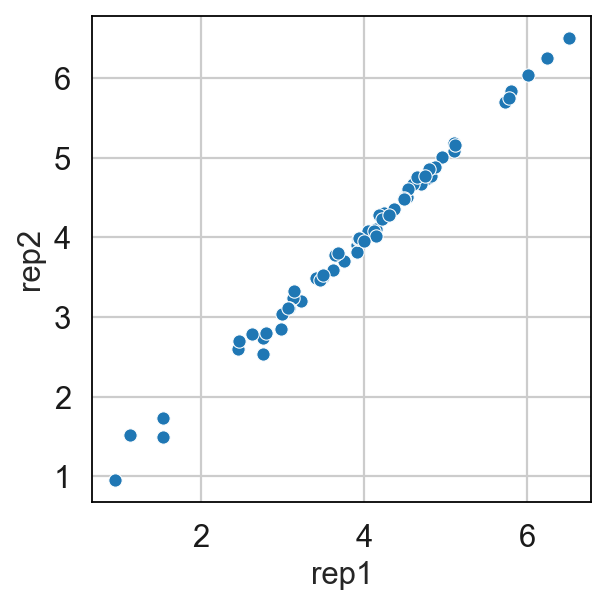

In [55]:
sns.scatterplot(x = 'rep1', y = 'rep2', data = pop_df_control_pivot)

In [56]:
pop_df_insert = pop_df.loc[pop_df.condition == 'insert']
pop_df_insert_pivot = pop_df_insert.pivot_table(index = 'gene', columns = 'rep', values = 'pseudo').reset_index()


<AxesSubplot:xlabel='rep1', ylabel='rep2'>

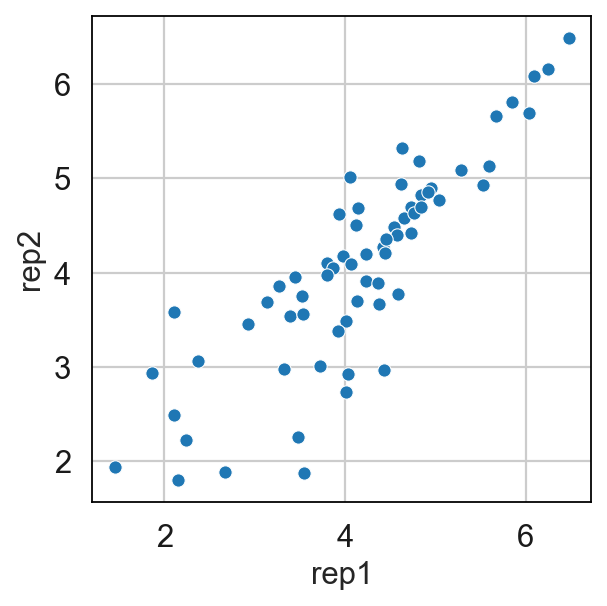

In [58]:
sns.scatterplot(x = 'rep1', y = 'rep2', data = pop_df_insert_pivot)

In [62]:
inserted_genes = list(set(pop_df['gene']))
pop = []
#inserted_genes.remove('ATG5')
for gene in inserted_genes:
    print(f'we are dealing with gene:{gene}')
    data_slice = pop_df.loc[pop_df.gene == gene]
    print(f'the length of the data slice is {len(data_slice)}')
    if len(data_slice) == 4:
        control = data_slice.loc[data_slice.condition == 'control', 'pseudo_int'].tolist()
        insert = data_slice.loc[data_slice.condition == 'insert', 'pseudo_int'].tolist()
        fc = np.log2(np.mean(insert)/np.mean(control))
        _, p_val = stats.fisher_exact(np.array([insert, control]))
        pop.append([gene, fc, p_val])
    else:
        clones = data_slice.clone.unique().tolist()
        for clone in clones:
            slice_slice_df = data_slice.loc[data_slice.clone == clone]
            control = slice_slice_df.loc[slice_slice_df.condition == 'control', 'pseudo_int'].tolist()
            insert = slice_slice_df.loc[slice_slice_df.condition == 'insert', 'pseudo_int'].tolist()
            fc = np.log2(np.mean(insert)/np.mean(control))
            _, p_val = stats.fisher_exact(np.array([insert, control]))
            pop.append([gene+'_'+clone, fc, p_val])

diff_exp_df= pd.DataFrame(pop, columns = ['gene', 'fc', 'p_val'])

we are dealing with gene:ZC3H12C
the length of the data slice is 4
we are dealing with gene:RABGAP1L
the length of the data slice is 4
we are dealing with gene:DEPDC1
the length of the data slice is 4
we are dealing with gene:PEX6
the length of the data slice is 4
we are dealing with gene:WDR12
the length of the data slice is 4
we are dealing with gene:CASK
the length of the data slice is 4
we are dealing with gene:CCND3
the length of the data slice is 4
we are dealing with gene:ERGIC2
the length of the data slice is 4
we are dealing with gene:CELF1
the length of the data slice is 4
we are dealing with gene:PNPLA8
the length of the data slice is 4
we are dealing with gene:SLAIN2
the length of the data slice is 4
we are dealing with gene:MKNK1
the length of the data slice is 4
we are dealing with gene:KREMEN1
the length of the data slice is 4
we are dealing with gene:HDAC8
the length of the data slice is 4
we are dealing with gene:GSE1
the length of the data slice is 4
we are dealing wi

gene is ZC3H12C
gene is SPRY1
gene is DOCK2
gene is ZFP69


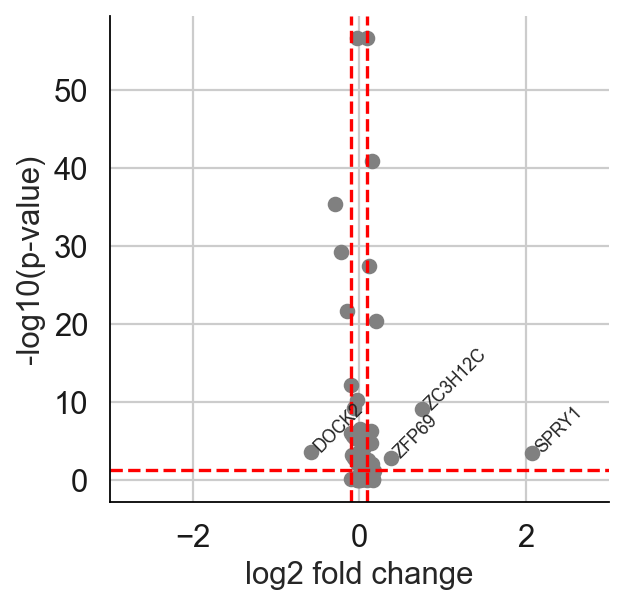

In [64]:
plt.plot(diff_exp_df.fc, -diff_exp_df.p_val.apply(np.log10), 'o',
         color='grey')
gene_names = diff_exp_df.gene.to_list()
for idx, gene in enumerate(gene_names):
    exp = diff_exp_df.loc[diff_exp_df.gene == gene, 'fc'].values[0]
    pval = diff_exp_df.loc[diff_exp_df.gene == gene, 'p_val'].values[0]
    if abs(exp)>= 0.3 and pval <= 0.05:
        plt.annotate(gene, (exp, -np.log10(pval)), rotation = 45, fontsize = 8)
        print(f'gene is {gene}')
plt.axvline( x = -0.1, color = 'red', linestyle = '--')
plt.axvline( x = 0.1, color = 'red', linestyle = '--')
plt.axhline(y = -np.log10(0.05), color = 'red', linestyle = '--')
plt.xlim(-3,3)
#plt.ylim(0,22)
plt.xlabel('log2 fold change')
plt.ylabel('-log10(p-value)')
sns.despine()
#plt.savefig('220420_insertion_effect_DE_randomly_shuffled.pdf', dpi = 300)